## Analysis of optimal number of providers in the market

This notebook analyzes an initial rough estimate for the target number of dog walkers needed to meet the demand for April 2024. Generally, the more providers in the market, the more transactions taking place, resulting in a higher revenue for the plaftform owner. However, acquiring more providers requires higher acquisition costs, hence, the target number must consider the tradeoff between revenue and cost. For the initial estimate, I solve a static optimization problem where I compare the platform owner’s revenue in April 2024 against total acquisition cost of achieving the target number of providers. In the future, I plan to extend this to a dynamic optimization framework where I compare the net present value of revenue against the recurrent cost of acquisition stemming from the assumption that unrequested providers churn.

The analysis assumes the followings:

Demand: 

[D1] There are expected to be 200 pet parents each needs to find a provider who will provide one walk per day for 5 consecutive days starting on a specific date. They seek a single provider to fulfill all their needs. 

[D2] Among the candidate set of providers shown to a pet parent, the pet parent contacts 4 different providers sequentially based on the provider's evaluation score. The evaluation score is the weighted average between a normalized price and a normalized the number of reviews. (The normalization is done by computing the percentage difference from the median. If the median price is 20 dollars and the provider’s list price is 25 dollars, then the normalized price is (25-20)/20 = 0.25).

Supply: 

[S1] Providers will deliver at most one walk per day.

[S2] Providers set their price for walks with the median price of $20.

[S3] Providers provide walk that begin and end at the pet parent’s location. Once contacted by a pet parent, the provider either accepts or rejects based solely on the distance to the parent’s location. The probability of acceptance decreases with the distance and the function passes through three points: 50 percent for 0.5 miles, 40 percent for 1 mile, and 5 percent for 10 miles. 

[S4] There are already 25 existing providers in the market. 

Platform: 

[R1] To construct a pool of providers for a given number of providers, the platform owner only looks within the 25 existing providers if the given number of provders is no more than 25. If the number is larger than 25, then the platform owner uses the 25 existing providers and fulfills the remainder using the newly acquired providers.

[R2] Given that the provider’s acceptance rate is less than 5% after 10 miles, to maximize the number of matches, for a given parent’s need, the platform owner shows the parent 10 closest providers who are located within 20 miles of the pet parent's location. 

[R3] The platform owner takes 20% of a provider’s list price for each walk.

[R4] The cost of acquisition for a provider (beyond the existing 25) is assumed to be $14 per provider.

Finally, the simulation exercise computes revenue and profit under differnet provider counts spanning from 20 to 38. The profit is computed based on revenue minus the cost of acquiring new providers beyond the existing 25.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import random
import datetime as dt

## Step 1: Load in data sets

In [2]:
df_exist_prov = pd.read_csv("../01 Input/existing_walkers.csv")
df_sim_needs = pd.read_csv("../01 Input/simulated_needs.csv")
df_sim_needs['start_date'] = pd.to_datetime(df_sim_needs['start_date'])
df_sim_new_prov = pd.read_csv("../01 Input/simulated_new_walkers.csv")

## Step 2: Define a class to navigate simulation

In [3]:
class SimulationModel:
    """
    Class to navigate simulate matches between providers and pet parents for a given provider counts
    """
    def __init__(self, num_prov, 
                        num_days,
                        num_parents,
                        num_max_parent_contacts,
                        parent_walk_days,
                        max_relevant_reviews,
                        parents_wgt,
                        num_existing_prov,
                        prov_walk_days,
                        med_price,
                        med_reviews,
                        rev_share,
                        num_prov_to_show,
                        cutoff_miles_to_show, 
                        num_prov_list_max,
                        random_numbers,
                        df_exist_prov,
                        df_sim_needs,
                        df_sim_new_prov):
        self.num_prov = num_prov
        self.num_days = num_days
        self.num_parents = num_parents
        self.num_max_parent_contacts = num_max_parent_contacts
        self.parent_walk_days = parent_walk_days
        self.max_relevant_reviews = max_relevant_reviews
        self.parents_wgt = parents_wgt
        self.num_existing_prov = num_existing_prov
        self.prov_walk_days = prov_walk_days
        self.med_price = med_price
        self.med_reviews = med_reviews
        self.rev_share = rev_share
        self.num_prov_to_show = num_prov_to_show
        self.cutoff_miles_to_show = cutoff_miles_to_show
        self.num_prov_list_max = num_prov_list_max
        self.random_numbers = random_numbers
        self.df_exist_prov = df_exist_prov
        self.df_sim_needs = df_sim_needs
        self.df_sim_new_prov = df_sim_new_prov
        
    
    def _create_needs_samp(self):
        """
        Creates a simulated sample of walk needs by parents
        
        Args:
            n_parents (int): number of parents

        Returns:
            pandas.DataFrame: A simulated sample of walk needs by parents
        """
        df_needs_samp = df_sim_needs.sample(n=self.num_parents, replace=False) \
                                    .reset_index(drop=True) \
                                    .reset_index() \
                                    .rename(columns={'index':'parent_id'}) \
                                    .set_index('parent_id')
        df_needs_samp['start_date_int'] = (df_needs_samp['start_date'] \
                                            - pd.to_datetime('2024-04-01')).dt.days
        df_needs_samp.drop(['start_date','end_date','simulated_need_id'], axis=1)
        return df_needs_samp
    
    def _create_prov_samp(self):
        """
        Creates a simulated sample of providers

        Args:
            n_prov (int): The number of providers to include in the simulated sample.  

        Returns:
            pandas.DataFrame: A simulated sample of providers
        """
        if self.num_prov <= self.num_existing_prov:
            df_prov_samp = df_exist_prov.sample(self.num_prov, replace=False) \
                                        .drop('provider_id', axis=1)
        else:
            df_exist = df_exist_prov.drop('provider_id', axis=1)
            n_prov_new = self.num_prov - self.num_existing_prov
            df_new = df_sim_new_prov.sample(n_prov_new, replace=False) \
                                    .drop('simulated_provider_id', axis=1)
            df_prov_samp = pd.concat([df_exist, df_new])

        df_prov_samp = df_prov_samp.reset_index(drop=True) \
                                    .reset_index() \
                                    .rename(columns={'index':'provider_id'}) \
                                    .set_index('provider_id')
        return df_prov_samp
    
    def _find_vac_prov(self, start_date_int, df_prov_samp, prov_tracker):
        """
        Finds providers who are available for certain consecutive days from a starting date
        
        Args:
            start_date_int (int): The starting date as an integer.
            df_prov_samp (pandas.DataFrame): A sample dataframe of providers.
            provider_availability_tracker (numpy.ndarray): A 2D numpy array that tracks provider availability.

        Returns:
            list: A list of provider indices who are available for certain consecutive days from a starting date
        """
        list_vac_prov = []
        for i_prov in range(len(df_prov_samp)):
            candidate_status = True
            for day in range(self.parent_walk_days):
                if prov_tracker[i_prov, start_date_int + day] <= 0:
                    candidate_status = False
            if candidate_status:
                list_vac_prov.append(i_prov)
        return list_vac_prov
    
    def _calc_dist_of_vac_prov(self, list_vac_prov, df_prov_samp, lat_parent, long_parent): 
        """
        Given a list of vacant providers and the parent location, output a Pandas DataFrame that 
            consists of distance

        Args:
            list_vac_prov (list): A list of providers available from a starting date
            df_prov_samp (pandas.DataFrame): A simulated sample of providers
            lat_parent (float): The latitude of the parent's location.
            long_parent (float): The longitude of the parent's location.

        Returns:
            pandas.DataFrame: A dataframe that consists of provider's distance 
        """
        list_vac_prov_dist = []

        for i_prov in list_vac_prov:
            dist = self._calc_dist_in_miles(lat_parent, 
                                    long_parent, 
                                    df_prov_samp.loc[i_prov, 'latitude'], 
                                    df_prov_samp.loc[i_prov, 'longitude'])
            list_vac_prov_dist.append(dist)     
                            
        return pd.DataFrame({'prov_id': list_vac_prov, 
                            'dist': list_vac_prov_dist})
        
    
    def _calc_prov_score(self, review_count, list_price):
        """
        Calculates pet parent's evaluation score for a given provider. 

        Args:
            review_count (float): The number of reviews the provider has
            list_price (float): The price the provider charges per walk

        Returns:
            float: The parent's evaluation score for the provider.
        """
        pct_dev_price = (self.med_price - list_price)/self.med_price
        adj_reviews = min(self.max_relevant_reviews, review_count)
        pct_dev_reviews = (adj_reviews - self.med_reviews)/self.med_reviews
        return self.parents_wgt*pct_dev_price + (1.0-self.parents_wgt)*pct_dev_reviews
    
    def _calc_dist_in_miles(self, loc1_lat, loc1_lon, loc2_lat, loc2_lon):
        """
        Calculates the distance between two locations in miles.

        Args:
            loc1_lat (float): The latitude of the first location.
            loc1_lon (float): The longitude of the first location.
            loc2_lat (float): The latitude of the second location.
            loc2_lon (float): The longitude of the second location.

        Returns:
            float: The distance between the two locations in miles.
        """    
        loc1_coord = (loc1_lat, loc1_lon)
        loc2_coord = (loc2_lat, loc2_lon)
        return geodesic(loc1_coord, loc2_coord).miles
    
    def _calc_prov_accept_prob(self, dist):
        """
        Calculates the probability in which a provider accepts the request given the distance to the job

        Args:
            dist (float): the distance to the job in miles
            
        Returns:
            float: The probability of acceptance by a provider
        """
        prob = 1.0
        if dist >= 0.0 and dist <= 0.5:
            prob = -dist + 1.0
        elif dist > 0.5 and dist <=1.0:
            prob = -0.2*dist + 0.6
        elif dist > 1.0 and dist <=2.0:
            prob = -0.15*dist + 0.55
        else:
            prob = 1.0/dist * 0.5
        return prob
    
    def _calc_info_of_vac_prov(self, df_nearby_prov, df_prov_samp): 
        """
            Given a Pandas DataFrame showing the list of nearby providers and distance to that provider, 
            return a Pandas DataFrame that consists of acceptance probability, provider evaluation score, and list price

        Args:
            df_nearby_prov (pandas.DataFrame): A dataframe of nearby providers with distance.
            df_prov_samp (pandas.DataFrame): A simulated sample of providers
            
        Returns:
            pandas.DataFrame: A dataframe that consists of provider's information relevant for evaluation by the parent.
        """
        list_vac_prov_prob = []
        list_vac_prov_score = []
        list_vac_prov_price = []

        for _, row in df_nearby_prov.iterrows():
        
            i_prov = row['prov_id'].astype(int)
            list_vac_prov_prob.append(self._calc_prov_accept_prob(row['dist']))
            
            score = self._calc_prov_score(df_prov_samp.loc[i_prov, 'review_count'], 
                                    df_prov_samp.loc[i_prov, 'list_price'])
            list_vac_prov_score.append(score)     
            list_vac_prov_price.append(df_prov_samp.loc[i_prov, 'list_price'])       
        
        df = df_nearby_prov.assign(prob=list_vac_prov_prob, score=list_vac_prov_score, price=list_vac_prov_price)

        return df
    
    
    def _calc_unmatched(self, prov_tracker):
        """
        Calculates the percentage of unmatched providers post simulation using the provider availability tracker
        
        Args:
            prov_tracker (numpy.ndarray): A 2D array representing the availability of providers for each day.

        Returns:
            float: The percentage of unmatched providers.
        """
        df_unfilled_walks = pd.DataFrame(prov_tracker.sum(axis=1), columns=['available'])
        df_unfilled_walks['f_unmatched'] = self.prov_walk_days * self.num_days == df_unfilled_walks['available']
        return df_unfilled_walks['f_unmatched'].mean()
    
    
    def calc_revenue_and_unmatches(self): 
        """
        Calculates revenue by conducting a simulation of matches between providers and parents in the given samples.

        Returns:
            tuple: A tuple of the total revenue generated by successfully matched transactions 
            and proportion of unmatched providers.
        """
                
        df_needs_samp = self._create_needs_samp()
        df_prov_samp = self._create_prov_samp()
        
        revenue = 0.0
        prov_tracker = np.ones((len(df_prov_samp), self.num_days)) * self.prov_walk_days
        prov_tracker = prov_tracker.astype(int)
        
        counter = 0
            
        for i_parent in range(self.num_parents):

            # find available providers for a given need      
            list_vac_prov = self._find_vac_prov(df_needs_samp.loc[i_parent, 'start_date_int'], 
                                        df_prov_samp, prov_tracker)
            
            # for each available provider, pulls info of distance
            df_vac_prov = self._calc_dist_of_vac_prov(list_vac_prov, 
                                                df_prov_samp, 
                                                df_needs_samp.loc[i_parent, 'latitude'],
                                                df_needs_samp.loc[i_parent, 'longitude'])

            # assume that the platform only shows nearby providers to parents to maximizes the match
            df_nearby_prov = df_vac_prov.sort_values(by='dist', ascending=True).head(self.num_prov_to_show)
            
            # the parent contacts providers with highest evaluation scores
            df_nearby_prov_w_info = self._calc_info_of_vac_prov(df_nearby_prov, df_prov_samp)
            df_highest_prov = df_nearby_prov_w_info.sort_values(by='score', ascending=False) \
                                                    .head(self.num_max_parent_contacts)
            
            unmatched = True
            for _, row in df_highest_prov.iterrows():
                counter += 1
                if unmatched:
                    prov_id = row['prov_id'].astype(int)
                    prob = row['prob']
                    price = row['price']
                    
                    if self.random_numbers[counter] < prob: # successful match!
                        unmatched = False
                        revenue += price * self.parent_walk_days * self.rev_share
                        # update provider availability tracker
                        for day in range(self.parent_walk_days):
                            prov_tracker[prov_id, df_needs_samp.loc[i_parent, 'start_date_int'] + day] += -1
            
        # calculate % of unmatched providers
        sh_unmatched_prov = self._calc_unmatched(prov_tracker)
        
        return (revenue, sh_unmatched_prov)  

## Step 3. Conduct simulation

In [4]:
num_prov_list = np.arange(20,40,2) # list of candidate number of providers 
num_prov_list_max = num_prov_list.max()
num_trials = 500 # specifies the number of simulations to conduct for a given number of proivders

In [5]:
num_days = 34 # number of days covering april 1, 2024 to may 4, 2024 (the last date of walk)
num_parents = 200 # the expected number of pet parents each needing to find a provider
num_max_parent_contacts = 4 # the maximum number of providers pet parents are willing to contact
parent_walk_days = 5 # the number of consecutive days a pet parent needs a walk for
max_relevant_reviews = 80 # the maxium number of review counts that pet parents care about 
parents_wgt = 0.2 # how much weight pet parent weigh on reviews vs prices

num_existing_prov = len(df_exist_prov) # the number of existing providers present in the market
prov_walk_days = 1 # the maximum number of walks a provider can deliver in a single day (at most 4)
med_price = 20 # median price charged by providers (per walk)
med_reviews = df_exist_prov['review_count'].median() # the median number of reviews

rev_share = 0.2 # platform's take rate for each transaction
num_prov_to_show = 10 # the maximum number of providers the platform shows to a pet parent
cutoff_miles_to_show = 20.0 # the maximum distance the platform shows to a pet parent

acqui_cost = 14.0 # per-provider cost of acquisition

In [6]:
def calc_profit(revenue_list, acqui_cost):
    """
    Calculates the profit for each provider count simulation given a per-provider acquisiton cost and revenue
    
    Args:
        revenue_list (list): The total revenue generated by successfully matched transactions
        acqui_cost (float): The monetary cost of acquiring a new provider

    Returns:
        list: A list of profits for each provider count
    """

    profit_list = []
    for idx, num_prov in enumerate(num_prov_list):
        if num_prov <= num_existing_prov:
            profit_list.append(revenue_list[idx])
        else:
            profit_list.append(revenue_list[idx] - acqui_cost * (num_prov-num_existing_prov))
        
    return profit_list

In [7]:
def experiment(): 
    """
    For each provider count, simulate Monte-Carlo experiment to compute the revenue and the percent unmatched.
     
    Returns:
        tuple: A tuple of three lists representing the simulated revenue, the percentage of unmatched providers, 
        and the simulated profit for different provider counts.
    """
    revenue_list = []
    unmatched_list = []
    revenue_result = np.zeros((num_trials, len(num_prov_list)))
    unmatched_prov_result = np.zeros((num_trials, len(num_prov_list)))
    
    # fix randomness of acceptance for all Monte Carlo simulations
    np.random.seed(2)
    random_numbers = np.random.uniform(0, 1, num_prov_list_max*num_parents)

    for idx, num_prov in enumerate(num_prov_list):
        print("Now computing simulated revenue for ", num_prov, " providers")
        model = SimulationModel(num_prov,
                                num_days,
                                num_parents,
                                num_max_parent_contacts,
                                parent_walk_days,
                                max_relevant_reviews,
                                parents_wgt,
                                num_existing_prov,
                                prov_walk_days,
                                med_price,
                                med_reviews,
                                rev_share,
                                num_prov_to_show,
                                cutoff_miles_to_show,
                                num_prov_list_max,
                                random_numbers,
                                df_exist_prov,
                                df_sim_needs,
                                df_sim_new_prov)

        for i in range(num_trials):
            rev, sh_unmatched_prov = model.calc_revenue_and_unmatches()
            revenue_result[i, idx] = rev
            unmatched_prov_result[i, idx] = sh_unmatched_prov
            
        # take average revenue for a given provider counts
        avg_rev = revenue_result[:, idx].mean() 
        avg_unmatched = unmatched_prov_result[:, idx].mean()
        revenue_list.append(avg_rev)
        unmatched_list.append(avg_unmatched)
        
    # calculate profit for a given assumption of acquisition cost
    profit_list = calc_profit(revenue_list, acqui_cost)
        
    return (revenue_list, unmatched_list, profit_list)

Now computing simulated revenue for  20  providers
Now computing simulated revenue for  22  providers
Now computing simulated revenue for  24  providers
Now computing simulated revenue for  26  providers
Now computing simulated revenue for  28  providers
Now computing simulated revenue for  30  providers
Now computing simulated revenue for  32  providers
Now computing simulated revenue for  34  providers
Now computing simulated revenue for  36  providers
Now computing simulated revenue for  38  providers


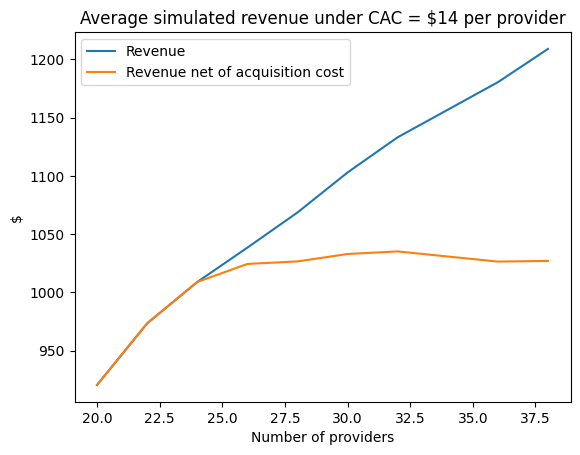

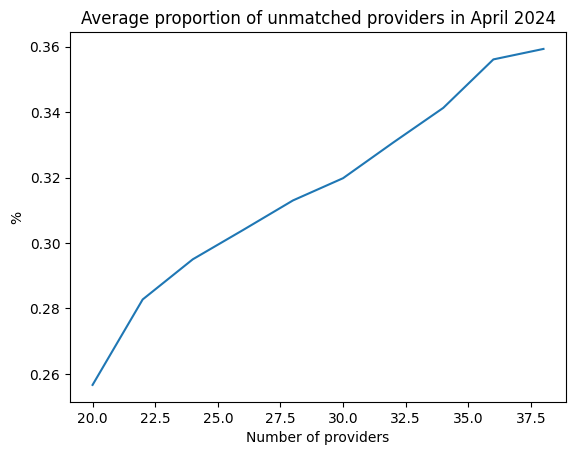

In [8]:
if __name__ == "__main__":
    
    # run Monte Carlo simulation to obtain revenue and share of unmatched providers
    revenue_list, unmatched_list, profit_list = experiment()
    
    # plot revenue and profit
    plt.plot(num_prov_list, revenue_list, label="Revenue")
    plt.plot(num_prov_list, profit_list, label="Revenue net of acquisition cost")
    plt.legend()
    plt.xlabel('Number of providers')
    plt.ylabel('$')
    plt.title('Average simulated revenue under CAC = $14 per provider')
    plt.show()
    
    # plot unmatched providers
    plt.plot(num_prov_list, unmatched_list)
    plt.xlabel('Number of providers')
    plt.ylabel('%')
    plt.title('Average proportion of unmatched providers in April 2024')
    plt.show()   


## Results

As expected, the revenue steadily increases as more providers are added to the market. Assuming that the per-provider cost of acquisition is $14, the profit gets maximized under around 32 providers.

## Future work

While the above approach captures the crucial components tied to the short-run revenue, there are assumptions that I would like to revisit.

[1] Refine or conduct sensitivity for cost of acquisition: Use historical/realistic provider cost of acquisition. The current model assumes a constant cost, but in reality, the per-provider cost may increase with the number of newly added providers (e.g., the marginal new provider would likely be harder to attain because they live far way or they're more royal to rival pet walking platforms).

[2] Dynamic optimization to take into account that unrequested providers churn the next month: As shown in the second figure, the proportion of unmatched providers increases as the number of providers increases (about 25% under 20 providers, 36% under 38 providers). The target number of providers would likely be lower if the platform owner takes into account the recurrent acquisition cost. Also, while the current model shows 10 closest providers to increase the match, to minimize the churn, it may make more sense to prioritize providers based on the number of requests so far. 

[3] Refine or conduct sensitivity analyses on provider's acceptance probability based on historical data. Instead of using the distance between two points, the model may fit the data better if I use a drive time between two points instead. Also, acceptance probabilities may differ depending on the number of walks the provider conducted in that month or on that day.

[4] Conduct sensitivity or provide more flexible model assumptions to accommodate heterogeneity in providers and pet parents based on historical data. I currently assumed that all providers walk at most once a day and all pet parents contact four providers with the same score function, which may not reflect the data. The weight between price and reviews may differ depending on the type of parents (e.g., new parents may care more about reviews, while repeated parents may care more about prices).

[5] General equilibrium effect: The current model assumes that providers' list price does not change based on the number of rival providers serving the platform owner. I plan to first check using historical data whether providers tend to price lower when they are faced with more rival providers. If so, I plan to incorporate that dynamic into the model. Also, this analysis does not consider any repercussions from rival platforms, which may be worth investigating.